In [100]:

print("hello world")

hello world


In [101]:
import datetime as dt
from collections import defaultdict

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
# from pyhht.visualization import plot_imfs
# from pyhht.emd import EmpiricalModeDecomposition

from functions import (bucketize_column, plot_the_loss_curve, create_model,
                       train_model, replace_with_linear_interpolation,
                       plot_the_loss_curves, tf_error, evaluate_model, predict_model,
                       np_error)

plt.rcParams.update({'figure.figsize': (7,7)})

In [102]:
def my_decompose(values, period, model='additive'):
    'multiplicative'
    result = seasonal_decompose(
        values, model=model, extrapolate_trend='freq', period=eval(period))

    # result.plot().suptitle(f'{model} Decompose {period}', fontsize=22)

    return result


def plot_seasonal(seasonal, period):
    fig, axs = plt.subplots(1, 2, figsize=(16,7))
    sections = np.split(seasonal, range(period, len(seasonal) - len(seasonal)%period, period))
    if len(sections[-1]) != period:
        del sections[-1]
    mean = np.mean(sections, axis=0)

    for section in sections:
        axs[0].plot(section)

    print(mean - seasonal[:period])

    axs[1].plot(seasonal)
    plt.show()


def apply(period, values):
    decomposed = my_decompose(values, period)
    decomposed.plot().suptitle(f'additive Decompose {period}', fontsize=22)
    plt.show()

    plot_seasonal(np.array(decomposed.trend), eval(period))
    plot_seasonal(np.array(decomposed.seasonal), eval(period))
    plot_seasonal(np.array(decomposed.resid), eval(period))

    values = values - decomposed.trend
    values = values - decomposed.seasonal

    return values, decomposed

In [103]:
train = pd.read_csv("train.csv")
train

,datetime,total
0,01.01.2005 00:00:00,?
1,01.01.2005 01:00:00,154140
2,01.01.2005 02:00:00,157818
3,01.01.2005 03:00:00,149311
4,01.01.2005 04:00:00,138282
...,...,...
35059,31.12.2008 19:00:00,249376
35060,31.12.2008 20:00:00,246511
35061,31.12.2008 21:00:00,226469
35062,31.12.2008 22:00:00,199907


In [104]:
train['total'].replace("?", -1000, inplace=True)
train['total'] = train['total'].astype(np.int32)

train[train['total'] <= 0]

,datetime,total
0,01.01.2005 00:00:00,-1000
3936,14.06.2005 00:00:00,-1000
3944,14.06.2005 08:00:00,-1000
3970,15.06.2005 10:00:00,-1000
3973,15.06.2005 13:00:00,-1000
...,...,...
34329,01.12.2008 09:00:00,-1000
34464,07.12.2008 00:00:00,-1000
34475,07.12.2008 11:00:00,-1000
34477,07.12.2008 13:00:00,-1000


In [105]:
time_format = "%d.%m.%Y %H:%M:%S"
train["datetime"] = [dt.datetime.strptime(s, time_format) for s in train["datetime"]]
train.sort_values(by=["datetime"], inplace=True)

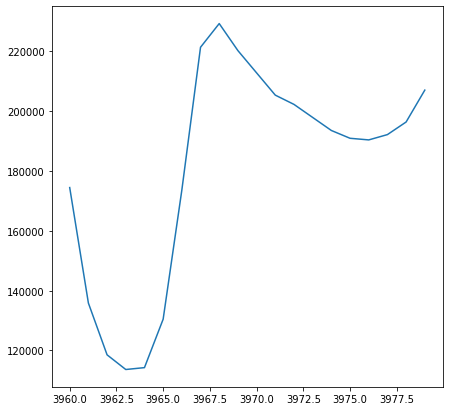

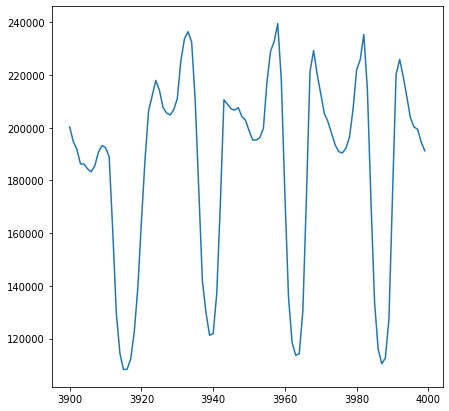

In [106]:
# replace non-positive values with linear interpolation
replace_with_linear_interpolation(train, train['total'] <= 0)

plt.plot(train[3960:3980]["total"])
plt.show()
plt.plot(train[3900:4000]["total"])
plt.show()

In [107]:
original_total = np.array(train["total"].copy())

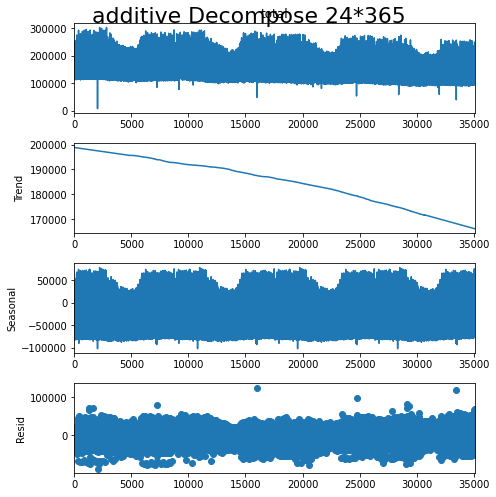

[-6162.45786499 -6162.87260543 -6163.15738011 ... -7285.7814688
 -7284.82929033 -7284.50351979]


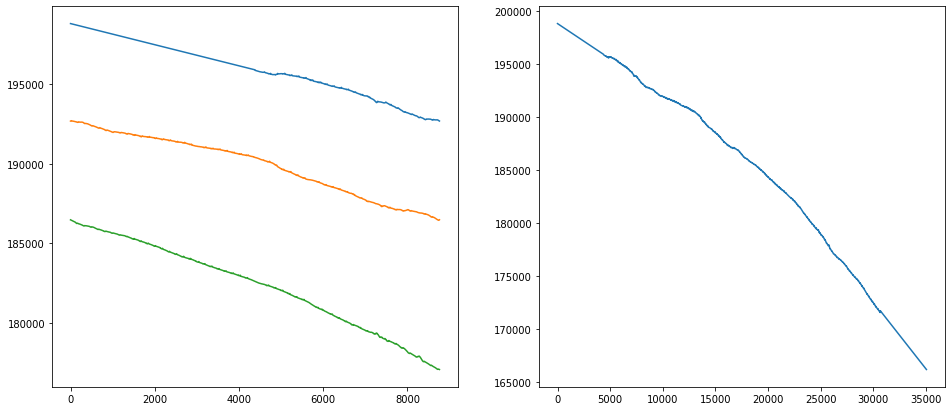

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -7.27595761e-12
  0.00000000e+00  0.00000000e+00]


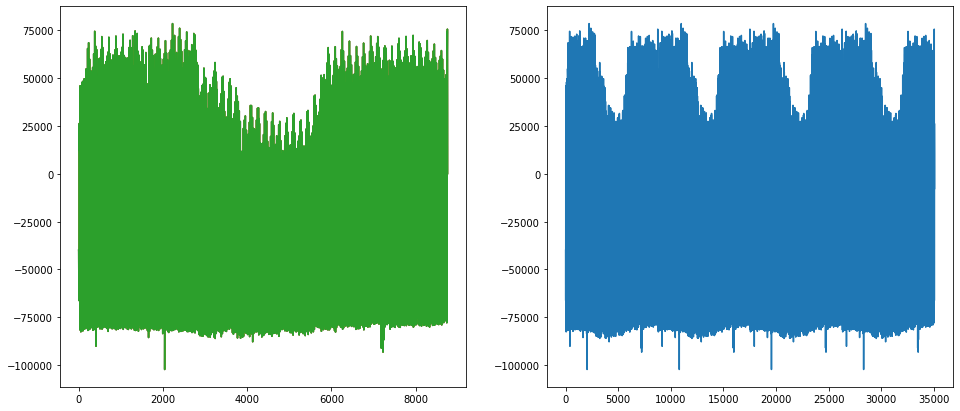

[-3571.20880168  1121.53927209  -731.17595322 ... -4310.88519787
 -1053.17070967  1065.17018645]


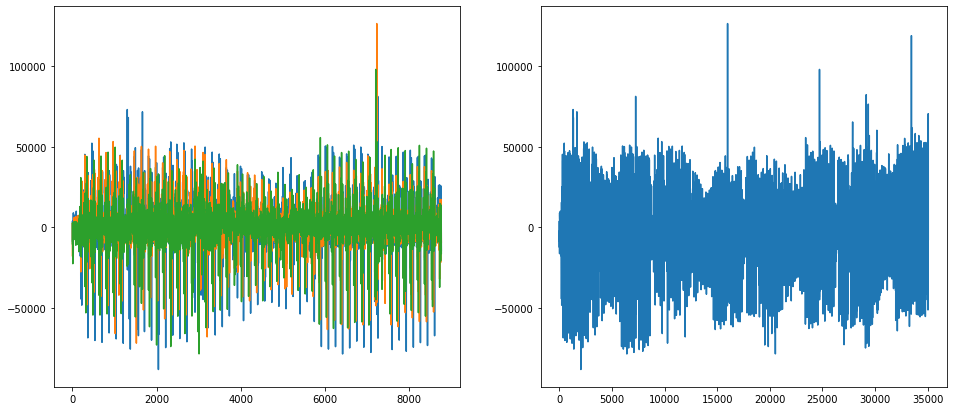

In [108]:
_, year_decomposed = apply("24*365", train["total"])

In [109]:
global_trend = year_decomposed.trend
train['total'] -= global_trend

In [110]:
global_trend_shift = np.mean(global_trend)
global_trend -= global_trend_shift

In [111]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


def func(x, a, b, c, e, f):
    return a * np.exp(-b * x) + c + e * (x + f)**2


# def func(x, a, b, c, d, e):
#     return a + b*x + c*x**2 + d*x**3 + e*x**4  # a*np.exp(-b*x) +


# def func(x, a, b, c, e, f, g, h):
#     return a * np.exp(-b * x) + c + e * f**2 + g * h**3


# def func(x, a, b, offset):
#     return 1.0 / (1.0 + np.exp(-a * (x-b))) + offset

# method : {'lm', 'trf', 'dogbox'}
popt, pcov = curve_fit(func, global_trend.index, global_trend)#, method='dogbox')
print(popt)
# [ 6.80965581e+02  5.54983660e+05  2.01353392e+05 -1.40515861e-05 1.50944272e+04]

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\pandas\core\indexes\base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


[ 6.80965596e+02  6.92481596e+05  1.63968906e+04 -1.40515862e-05
  1.50944270e+04]


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


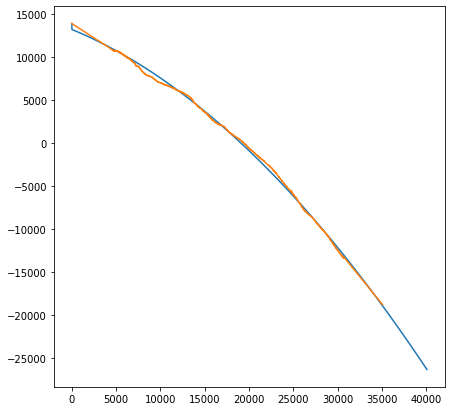

In [112]:
_x_data = np.arange(len(global_trend) + 5000)
plt.plot(_x_data, func(_x_data, *popt),
         label=f'fit: {popt}')#a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(global_trend, label="data")
plt.show()

In [113]:
# replace outlier values with linear interpolation
print(len(train[train['total'] < -100_000]) / len(train))

replace_with_linear_interpolation(train, train['total'] < -100_000)

0.0002851927903262606


In [114]:
train['total'].describe()

count     35064.000000
mean        182.310707
std       44510.593192
min      -98843.734361
25%      -27666.754693
50%       11630.643215
75%       32287.640240
max      105232.374088
Name: total, dtype: float64

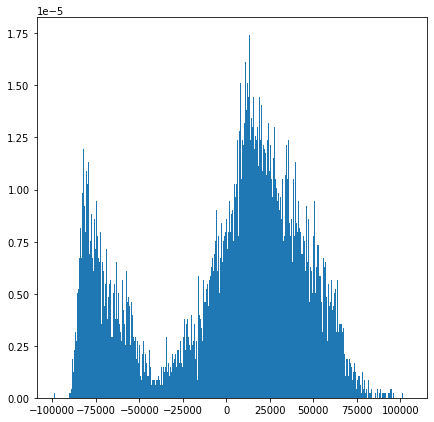

In [115]:
plt.hist(train["total"], 1500, density=True)
plt.show()

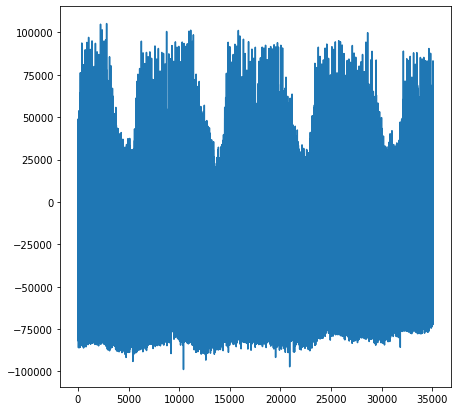

In [116]:
plt.plot(train["total"])

In [117]:
# decomposer = EmpiricalModeDecomposition(train["total"], maxiter=20000)
# imfs = decomposer.decompose()

In [118]:
# plt.plot(imfs[8])
# plt.show()

In [119]:
# plt.psd(train["total"], 5000, 1/0.01)
# plt.show()

In [120]:
# plt.plot(np.fft.fftshift(np.fft.fft(train["total"])))
# plt.show()
# plt.plot(np.fft.fft(train["total"]))
# plt.show()

In [121]:
# plot_imfs(train["total"], imfs, train.index)

In [122]:
# acfarray = np.array(list(enumerate(acf(train["total"], nlags=1024))))
# most_periods = acfarray[acfarray[:, 1].argsort()[::-1]][:, 0][1:].astype(int)

def get_the_best_period(values, nlags=1024):
    acfarray = np.array(list(enumerate(acf(values, nlags=nlags))))
    most_periods = acfarray[acfarray[:, 1].argsort()[::-1]][:, 0].astype(int)
    for period in most_periods:
        if period not in (0, 1):
            return period

0 24*365, 


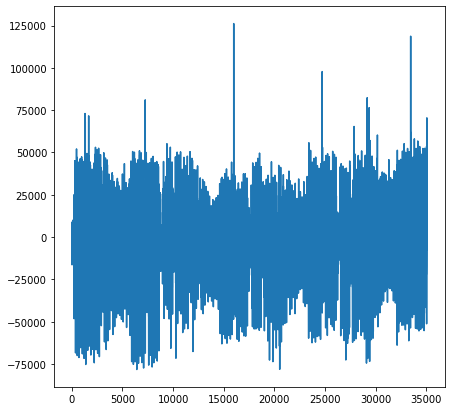

1 2, 


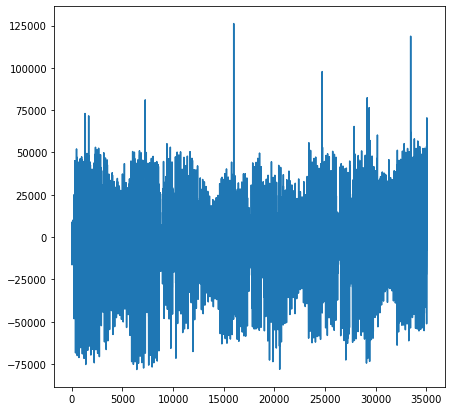

2 12, 


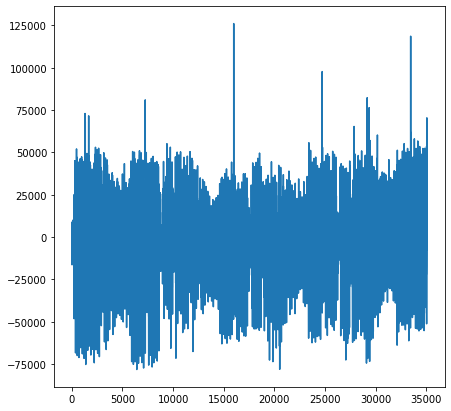

3 24, 


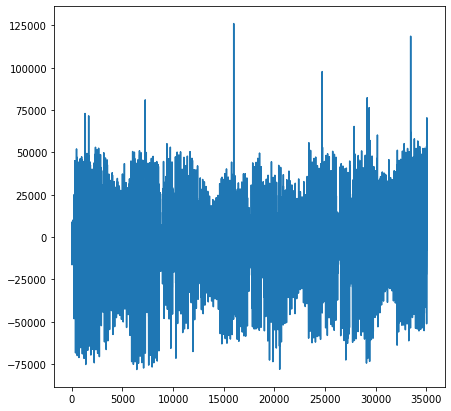

4 96, 


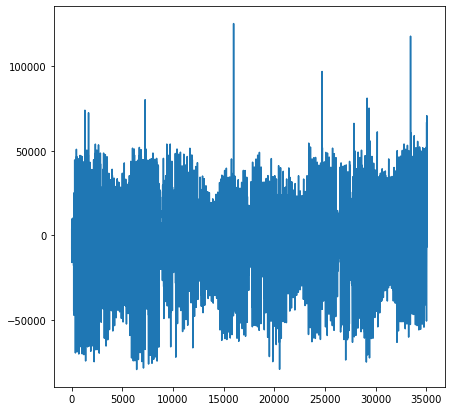

5 24*7*4, 


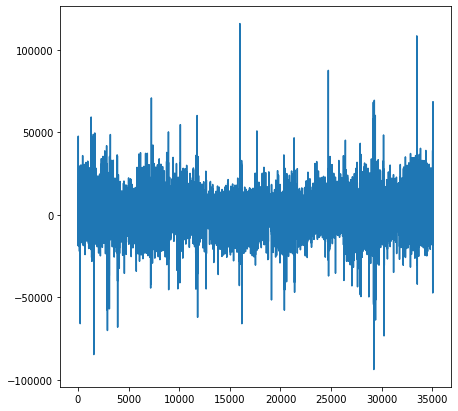

6 24*365//4, 


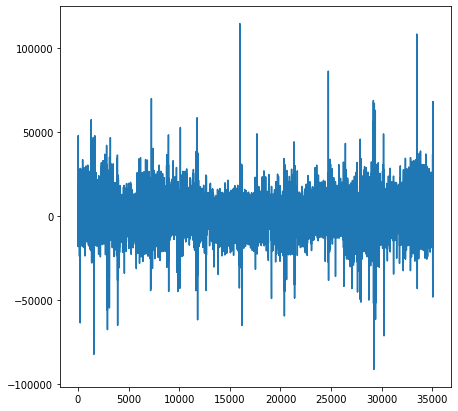

7 24*365//2, 


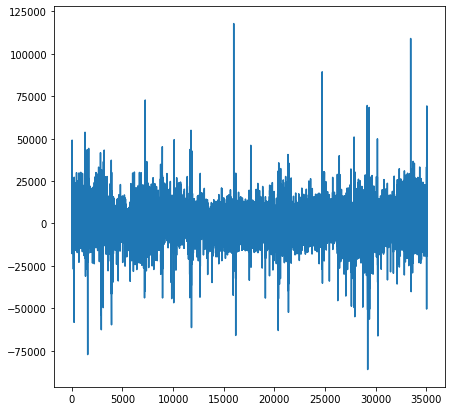

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. 

In [123]:
values = train["total"]
# periods = list(map(str, list(most_periods)))
periods = ["24*365", "2", "12", "24", "96", "24*7*4", "24*365//4", "24*365//2"]
old_seasonals = defaultdict(list)

for i, period in enumerate(periods):
    print(i, period, end=", ")
    decomposed = my_decompose(values, period)

    values -= decomposed.seasonal
    old_seasonals[period].append(decomposed.seasonal)

    print()
    plt.plot(values)
    plt.show()

seasonals = dict()
for period, seasonal in old_seasonals.items():
    period = eval(period)
    seasonal = np.sum(seasonal, axis=0)
    seasonal = seasonal[:len(seasonal) - len(seasonal)%period]

    sections = np.split(seasonal, range(period, len(seasonal), period))
    print(np.diff(sections, axis=0).T)
    seasonals[period] = np.mean(sections, axis=0)

In [25]:
for period, seasonal in seasonals.items():
    print(period)
    # plt.plot(seasonal)
    # plt.show()

168
1


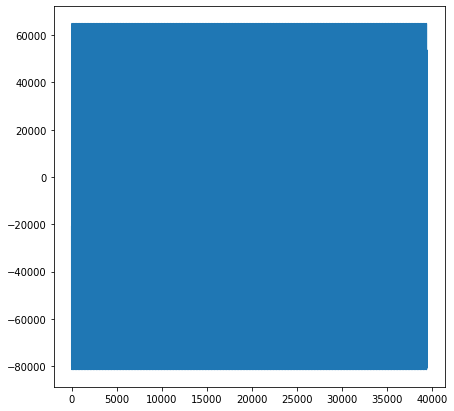

In [26]:
to_predict = 4344
neened_len = len(train) + to_predict

extended = np.zeros(neened_len)
for period, seasonal in seasonals.items():
    extended += np.tile(seasonal, int(np.ceil(neened_len/len(seasonal))))[:neened_len]

plt.plot(extended)
plt.show()

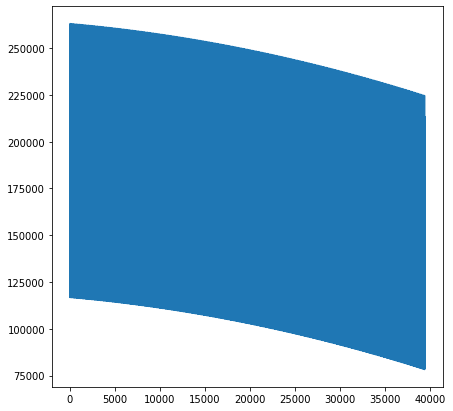

In [27]:
extended += func(np.arange(neened_len), *popt)
extended += global_trend_shift

plt.plot(extended)
plt.show()

In [28]:
# 01.01.2009 00:00:00 по 30.06.2009 23:00:00

last = train["datetime"][len(train)-1]
for _ in range(to_predict):
    last += dt.timedelta(hours=1)
    train.loc[train.shape[0]] = [last] + [pd.NA]*(len(train.columns)-1)
train[-to_predict+1:]

,datetime,total
35065,2009-01-01 01:00:00,<NA>
35066,2009-01-01 02:00:00,<NA>
35067,2009-01-01 03:00:00,<NA>
35068,2009-01-01 04:00:00,<NA>
35069,2009-01-01 05:00:00,<NA>
...,...,...
39403,2009-06-30 19:00:00,<NA>
39404,2009-06-30 20:00:00,<NA>
39405,2009-06-30 21:00:00,<NA>
39406,2009-06-30 22:00:00,<NA>


In [29]:
train["year"] = [date.year for date in train["datetime"]]
train["season"] = [date.month % 4 for date in train["datetime"]]
train["month"] = [date.month for date in train["datetime"]]
train["week_of_year"] = [date.isocalendar().week for date in train["datetime"]]
# train["week_of_month"] = [(date.day + date.replace(day=1).weekday() - 1)//7 for date in train["datetime"]]
train["is_weekend"] = [int(date.weekday() >= 5) for date in train["datetime"]]
train["weekday"] = [date.weekday() for date in train["datetime"]]
train["hour"] = [date.hour for date in train["datetime"]]

In [30]:
set([date.year for date in train["datetime"]])

{2005, 2006, 2007, 2008, 2009}

In [31]:
train["year"] -= 2005
train["year"] /= 4  # so 2009 would work

train["season"] /= 3

train["month"] -= 1
train["month"] /= 11

train["week_of_year"] -= 1
train["week_of_year"] /= 51

# train["week_of_month"] /= 4

train["weekday"] /= 6

train["hour"] /= 23

In [32]:
ind = len(train)-to_predict
X_submit = pd.DataFrame(train[ind:].values, columns=train.columns)
train.drop(train[ind:].index, inplace=True)
del X_submit["total"]
del X_submit["datetime"]
for column in X_submit.columns:
    X_submit[column] = X_submit[column].astype(np.float64)
X_submit

,year,season,month,week_of_year,is_weekend,weekday,hour
0,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.000000
1,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.043478
2,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.086957
3,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.130435
4,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.173913
...,...,...,...,...,...,...,...
4339,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.826087
4340,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.869565
4341,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.913043
4342,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.956522


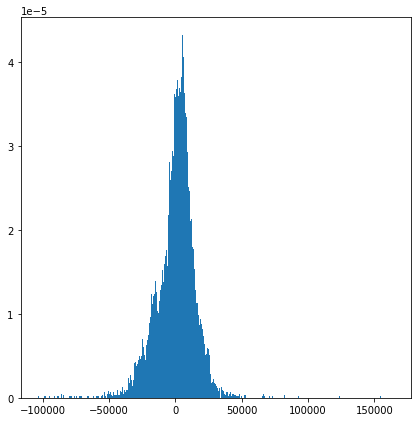

In [33]:
plt.hist(values, 1500, density=True)
plt.show()

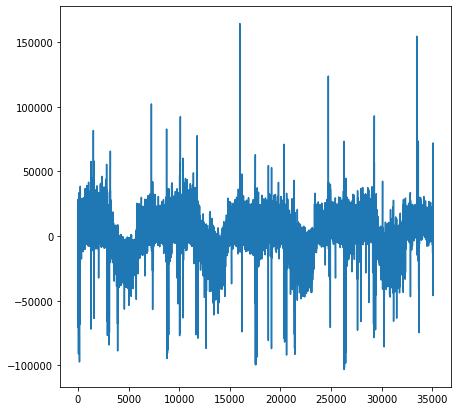

In [34]:
plt.plot(values[:])
plt.show()

[[ 0.00000000e+00 -1.58159734e+04]
 [ 1.00000000e+00 -1.56375344e+04]
 [ 2.00000000e+00 -1.54597362e+04]
 ...
 [ 3.50610000e+04  7.39544687e+03]
 [ 3.50620000e+04  7.38778229e+03]
 [ 3.50630000e+04  7.38041144e+03]]


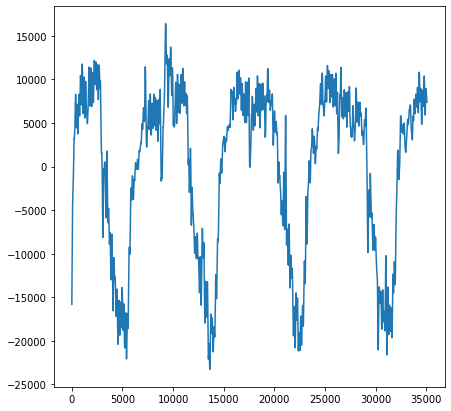

In [35]:
frac = 0.004
print(lowess(values, np.arange(len(values)), frac=frac))
train["leftovers"] = values

noise = train["leftovers"]

train["smoothed_leftovers"] = lowess(values, np.arange(len(values)), frac=frac)[:, 1]
plt.plot(train["smoothed_leftovers"])
plt.show()

In [36]:
train.sort_values(by=["season", "month", "is_weekend", "weekday", "hour", "week_of_year", "year"])

,datetime,total,year,season,month,week_of_year,is_weekend,weekday,hour,leftovers,smoothed_leftovers
2232,2005-04-04 00:00:00,3119.090683,0.00,0.0,0.272727,0.254902,0,0.0,0.0,3119.090683,12036.242688
10968,2006-04-03 00:00:00,3403.153896,0.25,0.0,0.272727,0.254902,0,0.0,0.0,3403.153896,10999.068693
19704,2007-04-02 00:00:00,11004.342195,0.50,0.0,0.272727,0.254902,0,0.0,0.0,11004.342195,7357.051708
2400,2005-04-11 00:00:00,137.765818,0.00,0.0,0.272727,0.274510,0,0.0,0.0,137.765818,11206.362886
11136,2006-04-10 00:00:00,332.603211,0.25,0.0,0.272727,0.274510,0,0.0,0.0,332.603211,9723.341439
...,...,...,...,...,...,...,...,...,...,...,...
7943,2005-11-27 23:00:00,2652.081814,0.00,1.0,0.909091,0.901961,1,1.0,1.0,2652.081814,6985.483542
16679,2006-11-26 23:00:00,13670.933812,0.25,1.0,0.909091,0.901961,1,1.0,1.0,13670.933812,9480.769455
25415,2007-11-25 23:00:00,9496.723538,0.50,1.0,0.909091,0.901961,1,1.0,1.0,9496.723538,10585.853422
34151,2008-11-23 23:00:00,9480.17472,0.75,1.0,0.909091,0.901961,1,1.0,1.0,9480.174720,8656.596470


In [37]:
train.describe()

,year,season,month,week_of_year,is_weekend,weekday,hour,leftovers,smoothed_leftovers
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,0.375257,0.498745,0.502085,0.499685,0.286105,0.499886,0.500000,181.639533,52.271538
std,0.279589,0.373802,0.313523,0.295280,0.451946,0.333538,0.300969,14648.219051,9548.361264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-103352.181146,-23294.028641
25%,0.250000,0.000000,0.272727,0.235294,0.000000,0.166667,0.250000,-6889.926162,-7422.127594
50%,0.500000,0.333333,0.545455,0.490196,0.000000,0.500000,0.500000,1754.588399,4176.862680
75%,0.750000,1.000000,0.818182,0.764706,1.000000,0.833333,0.750000,8568.404698,7400.595266
max,0.750000,1.000000,1.000000,1.019608,1.000000,1.000000,1.000000,164434.498667,16405.905623


In [38]:
train.corr()

,year,season,month,week_of_year,is_weekend,weekday,hour,leftovers,smoothed_leftovers
year,1.000000e+00,4.124187e-04,-1.204013e-03,-5.821027e-03,-3.289666e-03,-3.210946e-03,4.849968e-16,-0.003641,-0.008292
season,4.124187e-04,1.000000e+00,-6.780733e-02,-5.912926e-02,-1.926463e-03,1.676365e-03,-2.014111e-16,-0.023165,-0.039282
month,-1.204013e-03,-6.780733e-02,1.000000e+00,9.701007e-01,4.134813e-03,5.804036e-03,-8.924218e-17,-0.014947,-0.064051
week_of_year,-5.821027e-03,-5.912926e-02,9.701007e-01,1.000000e+00,6.006435e-03,6.484008e-03,-9.069401e-17,-0.026233,-0.070038
is_weekend,-3.289666e-03,-1.926463e-03,4.134813e-03,6.006435e-03,1.000000e+00,7.910701e-01,-8.554814e-18,-0.001321,-0.001166
weekday,-3.210946e-03,1.676365e-03,5.804036e-03,6.484008e-03,7.910701e-01,1.000000e+00,-1.147355e-18,-0.000685,-0.003392
hour,4.849968e-16,-2.014111e-16,-8.924218e-17,-9.069401e-17,-8.554814e-18,-1.147355e-18,1.000000e+00,0.000318,0.000474
leftovers,-3.641078e-03,-2.316542e-02,-1.494737e-02,-2.623269e-02,-1.321081e-03,-6.847991e-04,3.176416e-04,1.000000,0.667364
smoothed_leftovers,-8.291932e-03,-3.928183e-02,-6.405071e-02,-7.003839e-02,-1.165544e-03,-3.392142e-03,4.742277e-04,0.667364,1.000000


In [39]:
# plt.plot(train["season"])
# plt.plot(train["month"])
# plt.plot(train["is_weekend"][:24*7*2])
# plt.plot(train["weekday"][:24*7*2])
# plt.plot(train["hour"][:24*3])

In [40]:
feature_columns = []

numeric_year = tf.feature_column.numeric_column("year")
year = bucketize_column(numeric_year, -0.1, 1.1, 5+1)
feature_columns.append(year)

numeric_season = tf.feature_column.numeric_column("season")
season = bucketize_column(numeric_season, -0.1, 1.1, 4+1)
feature_columns.append(season)

numeric_month = tf.feature_column.numeric_column("month")
month = bucketize_column(numeric_month, -0.1, 1.1, 12+1)
feature_columns.append(month)

numeric_week_of_year = tf.feature_column.numeric_column("week_of_year")
week_of_year = bucketize_column(numeric_week_of_year, -0.1, 1.1, 52+1)
feature_columns.append(week_of_year)

numeric_is_weekend = tf.feature_column.numeric_column("is_weekend")
is_weekend = bucketize_column(numeric_is_weekend, -0.1, 1.1, 2+1)
feature_columns.append(is_weekend)

numeric_weekday = tf.feature_column.numeric_column("weekday")
weekday = bucketize_column(numeric_weekday, -0.1, 1.1, 7+1)
feature_columns.append(weekday)

numeric_hour = tf.feature_column.numeric_column("hour")
hour = bucketize_column(numeric_hour, -0.1, 1.1, 24+1)
feature_columns.append(hour)

season_x_weekday = tf.feature_column.crossed_column([season, weekday], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(season_x_weekday)
feature_columns.append(crossed_feature)

weekday_x_hour = tf.feature_column.crossed_column([weekday, hour], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(weekday_x_hour)
feature_columns.append(crossed_feature)

month_x_weekday = tf.feature_column.crossed_column([month, weekday], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(month_x_weekday)
feature_columns.append(crossed_feature)

In [41]:
learning_rate = 0.0002
# regularization_rate = 0.01
epochs = 300
batch_size = 30
validation_split = 0.15

selected = list(train.columns)
selected.remove("datetime")
selected.remove("total")
selected.remove("leftovers")
selected.remove("smoothed_leftovers")
label_name = "smoothed_leftovers"

on_full_data = False
if on_full_data:
    X_train, y_train = train[selected], train[label_name]
else:
    X_train, _, y_train, _ = train_test_split(train[selected], train[label_name], test_size=0.1)

feature_cross_feature_layer = layers.DenseFeatures(feature_columns)#, kernel_regularizer=regularizers.L1(regularization_rate))
# my_model = create_model(learning_rate, feature_cross_feature_layer)
# epochs, rmse, history = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)

# # ['loss', 'tf_error', 'val_loss', 'val_tf_error']
# plot_the_loss_curves(epochs, history["tf_error"],
#                     history["val_tf_error"])

In [42]:
if on_full_data:
    # X = pd.concat([train[selected], X_submit])
    X = X_submit
    extended = extended[-to_predict:]
else:
    X = train[selected][len(X_train):]
    extended = extended[len(X_train):len(train)]
# prediction = predict_model(my_model, X, batch_size).T[0]
# plt.plot(prediction)
# plt.show()

0.025879404992888887
original


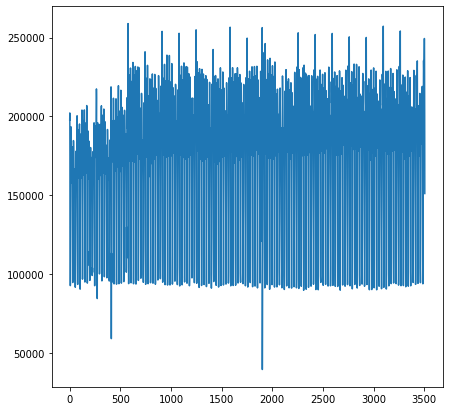

predicted


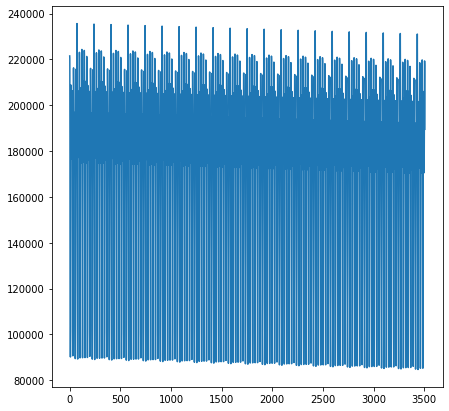

diff


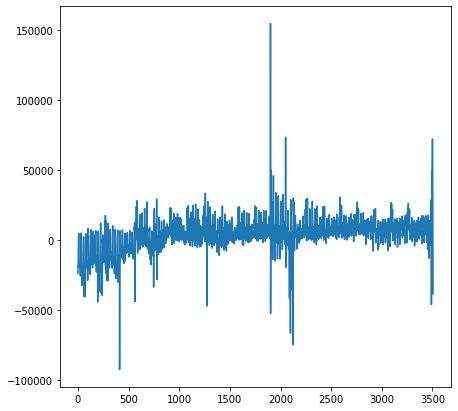

In [43]:
end_prediction = extended  # + prediction
if not on_full_data:
    a = original_total[len(X_train):]
    b = end_prediction
    print(np_error(a, b))
    print("original")
    plt.plot(a)
    plt.show()
    print("predicted")
    plt.plot(b)
    plt.show()
    print("diff")
    plt.plot(a - b)
    plt.show()

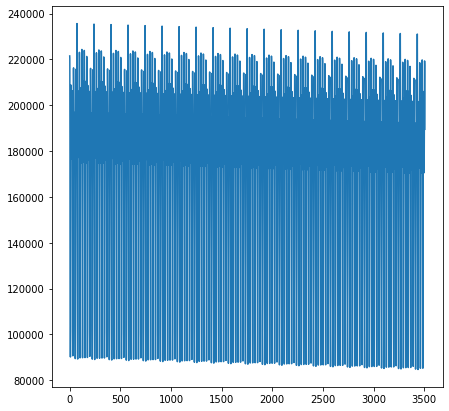

In [44]:
plt.plot(end_prediction)
plt.show()

In [45]:
if on_full_data:
    with open("answer2.txt", "w") as f:
        for v in end_prediction:
            f.write(str(v))
            f.write('\n')